Task 1:

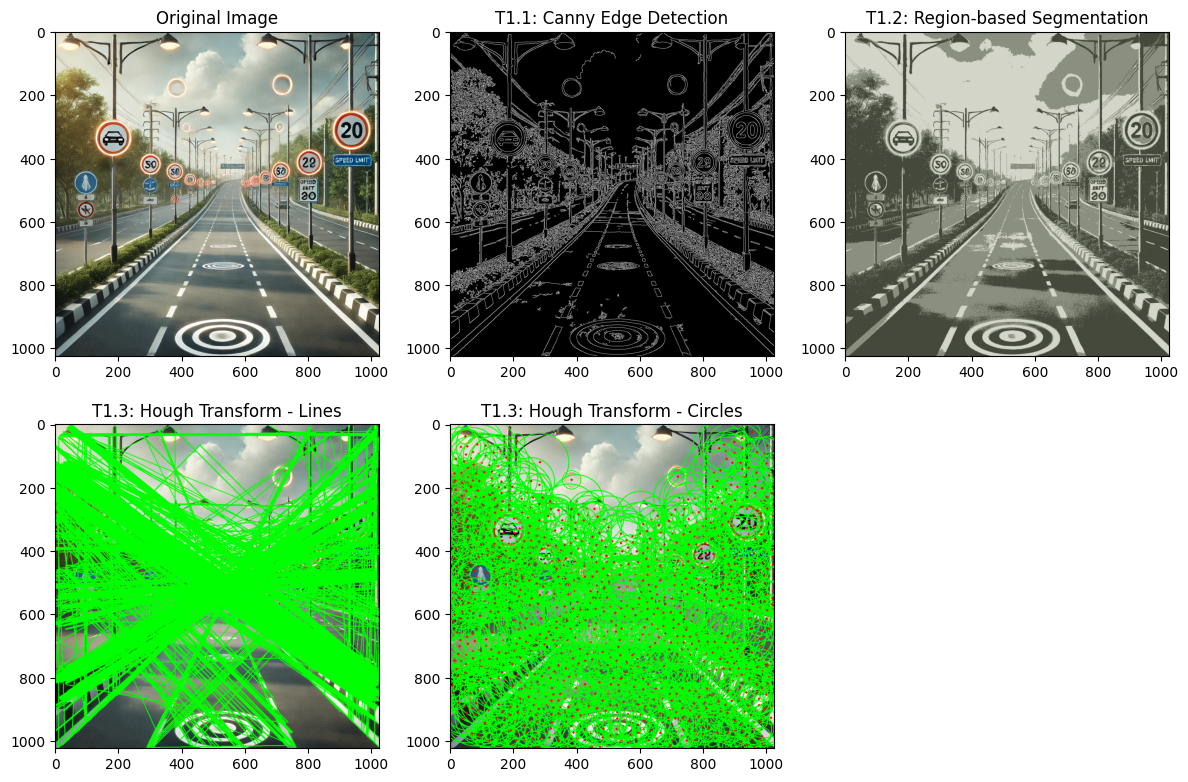

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = "/content/Road image.jpeg"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

""" T1.1 - Edge-based segmentation (Canny Edge Detection)"""
edges = cv2.Canny(gray, 50, 150)

""" T1.2 - Region-based segmentation """
def region_segmentation(image, k=3):
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    _, labels, centers = cv2.kmeans(pixel_values, k, None,
                                    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2),
                                    10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()].reshape(image.shape)

    return segmented_image

segmented_img = region_segmentation(image, k=3)

""" T1.3 - Hough Transform for Line and Circle Detection
Hough Line Transform"""
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 68, minLineLength=15, maxLineGap=250)
line_img = image.copy()

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

""" Hough Circle Transform"""
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=5, maxRadius=100)
circle_img = image.copy()

if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        cv2.circle(circle_img, (i[0], i[1]), i[2], (0, 255, 0), 2)
        cv2.circle(circle_img, (i[0], i[1]), 2, (0, 0, 255), 3)


plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title("Original Image")
plt.subplot(2, 3, 2), plt.imshow(edges, cmap="gray"), plt.title("T1.1: Canny Edge Detection")
plt.subplot(2, 3, 3), plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB)), plt.title("T1.2: Region-based Segmentation")
plt.subplot(2, 3, 4), plt.imshow(cv2.cvtColor(line_img, cv2.COLOR_BGR2RGB)), plt.title("T1.3: Hough Transform - Lines")
plt.subplot(2, 3, 5), plt.imshow(cv2.cvtColor(circle_img, cv2.COLOR_BGR2RGB)), plt.title("T1.3: Hough Transform - Circles")

plt.tight_layout()
plt.show()


Task 2.1


0: 640x640 1 person, 1 umbrella, 165.4ms
Speed: 5.9ms preprocess, 165.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


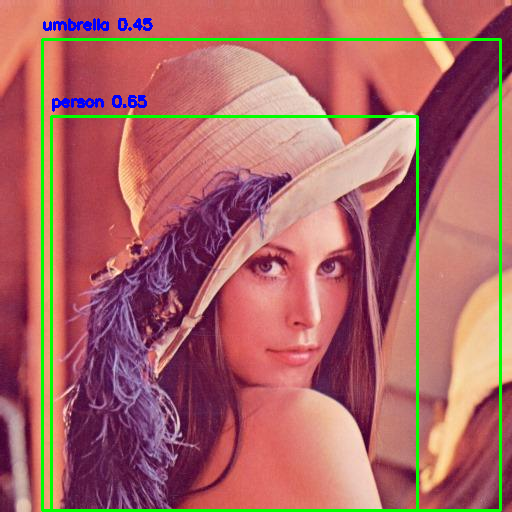

In [ ]:
import cv2
from ultralytics import YOLO
from google.colab.patches import cv2_imshow


model = YOLO('yolov8n.pt')

image_path = "/content/Lab-1 B-31 33 35 36 38.pdf-image-001.jpg"

image = cv2.imread(image_path)


results = model(image)


for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        label = result.names[int(box.cls)]
        confidence = box.conf[0].item()


        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, f"{label} {confidence:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)


cv2_imshow(image)


Task 2.2

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


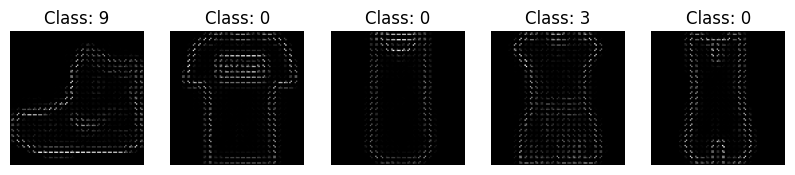

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - accuracy: 0.7784 - loss: 0.6144 - val_accuracy: 0.8719 - val_loss: 0.3431
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.8905 - loss: 0.3011 - val_accuracy: 0.8930 - val_loss: 0.2925
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.9061 - loss: 0.2578 - val_accuracy: 0.9005 - val_loss: 0.2708
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.9186 - loss: 0.2204 - val_accuracy: 0.8996 - val_loss: 0.2688
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - accuracy: 0.9263 - loss: 0.1989 - val_accuracy: 0.9107 - val_loss: 0.2548
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


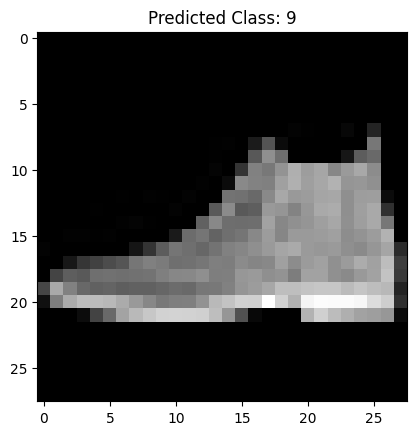

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from skimage.feature import hog
from skimage import exposure
from skimage.transform import resize


(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


def resize_image(image, size=(100, 100)):
    return resize(image, size, anti_aliasing=True)


def extract_hog_features(image):
    fd, hog_image = hog(image, pixels_per_cell=(4, 4), cells_per_block=(2, 2),
                        visualize=True, block_norm='L2-Hys')
    return hog_image


plt.figure(figsize=(10, 5))
for i in range(5):
    img = train_images[i]
    resized_img = resize_image(img)
    hog_img = extract_hog_features(resized_img)

    plt.subplot(2, 5, i+1)
    plt.imshow(hog_img, cmap='gray')
    plt.title(f"Class: {train_labels[i]}")
    plt.axis("off")

plt.show()


model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


train_images = train_images.reshape(-1, 28, 28, 1) / 255.0
test_images = test_images.reshape(-1, 28, 28, 1) / 255.0
model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))



test_image = test_images[0].reshape(1, 28, 28, 1)
prediction = np.argmax(model.predict(test_image))

plt.imshow(test_images[0].reshape(28, 28), cmap="gray")
plt.title(f"Predicted Class: {prediction}")
plt.show()
